In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import Cityscapes
from torchvision import transforms

import matplotlib.pyplot as plt


In [2]:
# ============================================================
# 1. Cityscapes 34 → 19 mapping
# ============================================================

ID_2_TRAINID = {
     0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
     7: 0,    # road
     8: 1,    # sidewalk
     9: 255, 10:255,
    11: 2,    # building
    12: 3,    # wall
    13: 4,    # fence
    14:255, 15:255, 16:255,
    17: 5,    # pole
    18:255,
    19: 6,    # traffic light
    20: 7,    # traffic sign
    21: 8,    # vegetation
    22: 9,    # terrain
    23:10,    # sky
    24:11,    # person
    25:12,    # rider
    26:13,    # car
    27:14,    # truck
    28:15,    # bus
    29:16,    # train
    30:17,    # motorcycle
    31:18,    # bicycle
    32:255, 33:255,
}


def encode_mask(mask):
    """
    mask: numpy array (H, W) with values 0..33 (Cityscapes IDs)
    returns: numpy array (H, W) with 0..18 (train IDs) and 255 as ignore
    """
    encoded = np.zeros_like(mask, dtype=np.uint8)
    for id_, tid in ID_2_TRAINID.items():
        encoded[mask == id_] = tid
    return encoded


In [3]:
# ============================================================
# 2. Cityscapes dataset wrapper
# ============================================================

class Cityscapes19(Dataset):
    def __init__(self, root, split="train"):
        self.dataset = Cityscapes(
            root=root,
            split=split,
            mode="fine",
            target_type="semantic",
        )

        self.img_transform = transforms.Compose([
            transforms.Resize((256, 512)),
            transforms.ToTensor(),
        ])

        # VERY IMPORTANT: use NEAREST for masks
        self.mask_resize = transforms.Resize(
            (256, 512),
            interpolation=Image.NEAREST
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]     # mask is a PIL Image (0..33 IDs)

        img = self.img_transform(img)

        mask = self.mask_resize(mask)
        mask = np.array(mask, dtype=np.uint8)  # raw labels [0..33]
        mask = encode_mask(mask)               # remap → 0..18 & 255
        mask = torch.as_tensor(mask, dtype=torch.long)

        return img, mask


In [4]:
# ============================================================
# 3. Simple U-Net with Channel Attention on skip connections
# ============================================================

class ChannelAttention(nn.Module):
    """
    Simple channel attention:
    - Global Avg Pool
    - 1x1 Conv -> ReLU -> 1x1 Conv -> Sigmoid
    - Multiply weights with input
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [B, C, H, W]
        w = self.avg_pool(x)      # [B, C, 1, 1]
        w = self.mlp(w)           # [B, C, 1, 1]
        return x * w              # channel-wise scaling


class DoubleConv(nn.Module):
    """
    Conv -> ReLU -> Conv -> ReLU
    (no BatchNorm to keep it very simple)
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class SimpleUNetWithChannelAttention(nn.Module):
    """
    Very simple U-Net:
    - 3 levels encoder / decoder
    - ChannelAttention on skip features
    - Bilinear upsampling
    """
    def __init__(self, in_channels=3, num_classes=19, base_ch=32):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, base_ch)        # 32
        self.enc2 = DoubleConv(base_ch, base_ch * 2)        # 64
        self.enc3 = DoubleConv(base_ch * 2, base_ch * 4)    # 128

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_ch * 4, base_ch * 8)  # 256

        # Channel Attention on skip connections
        self.ca1 = ChannelAttention(base_ch)         # for enc1
        self.ca2 = ChannelAttention(base_ch * 2)     # for enc2
        self.ca3 = ChannelAttention(base_ch * 4)     # for enc3

        # Decoder
        self.dec3 = DoubleConv(base_ch * 8 + base_ch * 4, base_ch * 4)
        self.dec2 = DoubleConv(base_ch * 4 + base_ch * 2, base_ch * 2)
        self.dec1 = DoubleConv(base_ch * 2 + base_ch, base_ch)

        # Final 1x1 conv to get class logits
        self.out_conv = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def upsample(self, x, target_feature):
        """
        Bilinear upsampling to match the spatial size of target_feature.
        """
        return F.interpolate(
            x,
            size=target_feature.shape[2:],
            mode="bilinear",
            align_corners=False
        )

    def forward(self, x):
        # ----- Encoder -----
        x1 = self.enc1(x)               # [B, 32,  H,   W]
        x2 = self.enc2(self.pool(x1))   # [B, 64,  H/2, W/2]
        x3 = self.enc3(self.pool(x2))   # [B, 128, H/4, W/4]

        # ----- Bottleneck -----
        xb = self.bottleneck(self.pool(x3))  # [B, 256, H/8, W/8]

        # ----- Apply Channel Attention on skip features -----
        s3 = self.ca3(x3)
        s2 = self.ca2(x2)
        s1 = self.ca1(x1)

        # ----- Decoder -----
        # Up from bottleneck, concat with s3
        d3 = self.upsample(xb, s3)
        d3 = torch.cat([d3, s3], dim=1)      # [B, 256+128, H/4, W/4]
        d3 = self.dec3(d3)                   # -> [B, 128, H/4, W/4]

        # Up, concat with s2
        d2 = self.upsample(d3, s2)
        d2 = torch.cat([d2, s2], dim=1)      # [B, 128+64, H/2, W/2]
        d2 = self.dec2(d2)                   # -> [B, 64, H/2, W/2]

        # Up, concat with s1
        d1 = self.upsample(d2, s1)
        d1 = torch.cat([d1, s1], dim=1)      # [B, 64+32, H, W]
        d1 = self.dec1(d1)                   # -> [B, 32, H, W]

        # Output logits
        out = self.out_conv(d1)              # [B, num_classes, H, W]
        return out

In [5]:
# ============================================================
# 4. mIoU + visualization helpers
# ============================================================

def compute_iou(preds, labels, num_classes=19):
    """
    Compute IoU for each class, ignoring label 255.
    preds, labels: torch tensors
    """
    # Flatten
    preds = preds.view(-1)
    labels = labels.view(-1)

    # Ignore index 255
    valid = labels != 255
    preds = preds[valid]
    labels = labels[valid]

    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float("nan"))
        else:
            ious.append(intersection / union)
    return ious


CITYSCAPES_PALETTE_19 = np.array([
    (128, 64,128), (244, 35,232), (70, 70, 70), (102,102,156),
    (190,153,153), (153,153,153), (250,170, 30), (220,220,  0),
    (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60),
    (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
    (  0, 80,100), (  0,  0,230), (119, 11, 32)
], dtype=np.uint8)


def decode_segmap(mask):
    """
    mask: (H, W) array with class ids 0..18
    returns: (H, W, 3) RGB image
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(19):
        rgb[mask == cls_id] = CITYSCAPES_PALETTE_19[cls_id]
    return rgb

In [6]:
# ============================================================
# 5. Training loop with mIoU, visualization, save
# ============================================================

root = "../cityscapes/"  # path to Cityscapes dataset

num_classes = 19
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Datasets and loaders
train_ds = Cityscapes19(root, split="train")
val_ds   = Cityscapes19(root, split="val")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=2, pin_memory=True)

# Model with channel attention
model = SimpleUNetWithChannelAttention(
    in_channels=3,
    num_classes=num_classes,
    base_ch=32,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 30 epochs
for epoch in range(30):
    # ------------------- Train -------------------
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # ------------------- Validation -------------------
    model.eval()
    val_loss = 0.0
    total_ious = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1)
            total_ious.append(
                compute_iou(preds.cpu(), masks.cpu(), num_classes=num_classes)
            )

    val_loss = val_loss / len(val_loader)

    # total_ious: list of [num_classes] → (N, C)
    total_ious = np.array(total_ious)  # shape (num_batches, num_classes)
    class_iou = np.nanmean(total_ious, axis=0)  # mean per class
    mean_iou = np.nanmean(class_iou)            # mean over classes

    print(
        f"Epoch {epoch+1}/30  "
        f"Train Loss: {train_loss:.4f}  "
        f"Val Loss: {val_loss:.4f}  "
        f"mIoU: {mean_iou:.4f}"
    )

# ====================================================
# Save model
# ====================================================
save_path = "unet_cityscapes_ca.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Using device: cuda
Epoch 1/30  Train Loss: 1.6417  Val Loss: 1.2987  mIoU: 0.0882
Epoch 2/30  Train Loss: 1.0859  Val Loss: 0.9876  mIoU: 0.1302
Epoch 3/30  Train Loss: 0.9104  Val Loss: 0.8801  mIoU: 0.1537
Epoch 4/30  Train Loss: 0.7877  Val Loss: 0.7815  mIoU: 0.1713
Epoch 5/30  Train Loss: 0.7253  Val Loss: 0.7175  mIoU: 0.1830
Epoch 6/30  Train Loss: 0.6680  Val Loss: 0.6556  mIoU: 0.2025
Epoch 7/30  Train Loss: 0.6334  Val Loss: 0.6674  mIoU: 0.1989
Epoch 8/30  Train Loss: 0.6080  Val Loss: 0.6162  mIoU: 0.2090
Epoch 9/30  Train Loss: 0.5802  Val Loss: 0.6093  mIoU: 0.2079
Epoch 10/30  Train Loss: 0.5622  Val Loss: 0.5819  mIoU: 0.2165
Epoch 11/30  Train Loss: 0.5447  Val Loss: 0.5780  mIoU: 0.2160
Epoch 12/30  Train Loss: 0.5234  Val Loss: 0.5678  mIoU: 0.2177
Epoch 13/30  Train Loss: 0.5056  Val Loss: 0.5522  mIoU: 0.2316
Epoch 14/30  Train Loss: 0.4917  Val Loss: 0.5108  mIoU: 0.2354
Epoch 15/30  Train Loss: 0.4794  Val Loss: 0.5231  mIoU: 0.2371
Epoch 16/30  Train Loss: 0.462

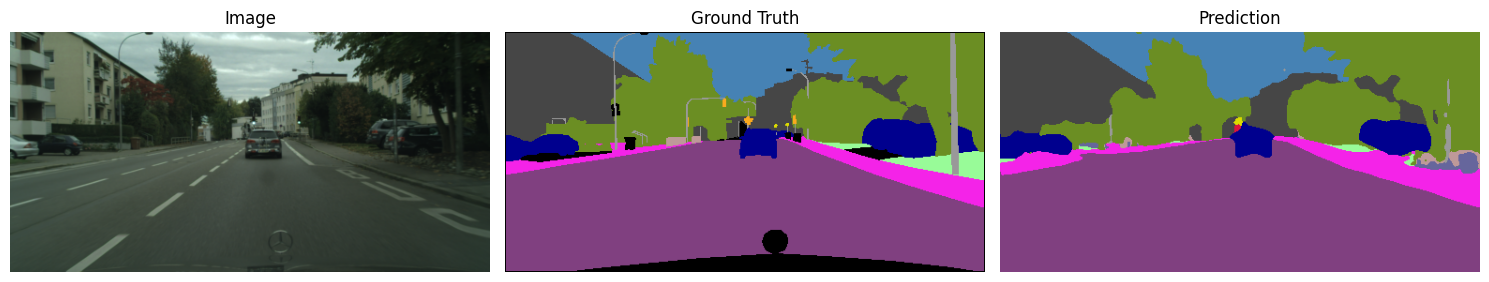

In [15]:
# ====================================================
# Visualization on one validation sample
# ====================================================
model.eval()
img, mask = val_ds[45]  # img: tensor, mask: tensor (H,W)
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

img_np = img.permute(1, 2, 0).numpy()
gt_rgb = decode_segmap(mask.numpy())
pred_rgb = decode_segmap(pred)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_np);   plt.title("Image");        plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(gt_rgb);   plt.title("Ground Truth"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(pred_rgb); plt.title("Prediction");   plt.axis("off")

plt.tight_layout()
plt.show()